In [9]:
import pandas as pd
import numpy as np
import glob
from OrderNpersist import Persist_tracks,Order_tracks2,to_vecs

from analyse_tracks import new_auto,auto_cor_pooled
from numpy.linalg import norm
from itertools import product
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'ANLSYS2')
from Cplus_ANLS import local_order

In [4]:
files = glob.glob('../data/real_cells/exp*.txt')
# goal : 
# speed , persist, order, local order per video
# std of all these measures : 

In [5]:
# for filename in files: 
#     # extract tracks : 
#     df = pd.read_csv(filename, sep="\t", names=['cell_id', 'time_id', 'time', 'x', 'y', 'z'])   
#     df['experiment'] = filename[19:28]
#     df['cell_type'] = filename[29:32]
#     df['movie'] = filename[38:39]
#     ids = df.cell_id.unique()
#     tracks = [df[df.cell_id == i][['x','y','z']].to_numpy() for i in ids]
#     # filter out super short tracks: 
#     tracks = [t for t in tracks if len(t) > 50]
    


In [6]:
x = np.array([4,5,6])
np.sum([x,x])

30

In [7]:
from collections import defaultdict

"""Accepts a python list of 3D spatial points, e.g. [[x1,y1,z1],...],
optionally with weights e.g. [[x1,x2,x3,w1],...], and returns the sparse
histogram (i.e. no empty bins) with bins of resolution (spacing) given by
res.
The weights option allows you to chose to histogram over counts
instead of weights (equivalent to all weights being 1).
The bin_index option lets you return the points with their bin indices 
(the integers representing how many bins in each direction to walk to 
find the specified bin) rather than centerpoint coordinates."""
def sparse_hist(points, res, weights=True, bin_index=False):
    def _binindex(point):
        point = point[0]
        bi = [int(x//res) for x in point]
        bi = tuple(bi)
        return bi

    def _bincenter(point):
        point = point[0]
        bc = [(x//res+0.5)*res for x in point]
        bc = tuple(bc)
        return bc

    if not bin_index:
        if weights:
            pointlist = [(_bincenter(x), x[1]) for x in points]
        else:
            pointlist = [(_bincenter(x), 1) for x in points]
    else:
        if weights:
            pointlist = [(_binindex(x), x[1]) for x in points]
        else:
            pointlist = [(_binindex(x), 1) for x in points]

    pointdict = defaultdict(list)
    for k,v in pointlist:
        pointdict[k].append(v)

    for key,val in pointdict.items():
        val = sum(val)
        pointdict.update({key:val})

    return pointdict

In [8]:
def Global_order(vec_tracks):
    # sum vec instead of calculating angles : 
    orders = 0
    for vtrack in vec_tracks:
        for v in vtrack:
            orders += v
    return norm(orders)

def OrderAt_T(vec_tracks):
    # find smallest track : 
    min_length = min([len(t) for t in vec_tracks])
    
    # reshape vectors to square matrix : 
    vt2 = np.zeros((len(vec_tracks),min_length,3))
    for i,v in enumerate(vec_tracks):
        vt2[i] = v[:min_length]
                   
    print(vt2.shape)
    orders = []
    for i in range(min_length):
        vecs_at_t = vt2[:,i]
        ordr = 0
        for v in vecs_at_t:
            ordr += v
        orders.append(ordr)
    print('lenght of order shoulde be min_lenght. Min_lenght',min_length,'==',len(orders))
    av_ordr = np.average([norm(v) for v in orders])
    std_ordr = np.std([norm(v) for v in orders])
        
    return av_ordr,std_ordr

def local_order(tracks,bins = 5):
    # find smallest track : 
    min_length = min([len(t) for t in vec_tracks])
    flat_tracks = [item for sublist in tracks for item in sublist.flatten()]
    max_d = max(flat_tracks) # end of domain : 
    # reshape vectors to square matrix : 
    vt2 = np.zeros((len(vec_tracks),min_length,3))
    for i,v in enumerate(vec_tracks):
        vt2[i] = v[:min_length]
    
    # go through vectors per timestep :
    orders = []
    for i in range(min_length):
        # bin according to position :
        vecs_at_t = vt2[:,i]
        pos = [tracks[j][i] for j in range(len(vecs_at_t))]
        binned_pos = np.digitize(pos,np.linspace(10,max_d,bins))
        # loop over bins : 
        for bn in np.unique(binned_pos,axis = 0):
            # find bins vectors in same bins : 
            indcs = [all(x) for x in binned_pos == bn] #binned_pos.all(bn)
            vecs_n_bin = vecs_at_t[indcs]
            # consider at least 2 cells in one bin :
            if len(vecs_n_bin) < 2:
                continue
            # sum 
            norm_bin = norm(sum(vecs_n_bin))
            orders.append(norm_bin)
    return orders

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


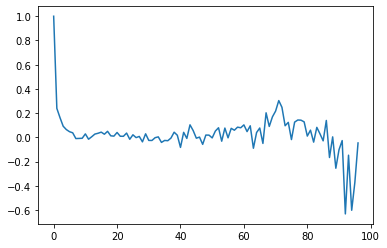

7
5
8
5
6
5
5
5
5
7
6
5
5
5
10
7
5
5
9
5
6
7
5
6
6
8
8
7
5
5
6
7
5
6
(303, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


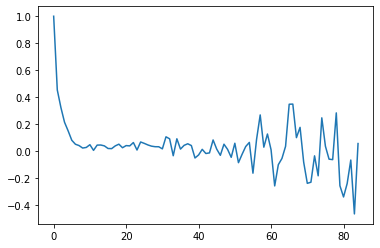

5
8
5
5
7
6
5
12
7
5
7
9
5
5
11
5
5
5
7
5
5
7
6
7
6
5
5
5
7
5
5
6
5
5
7
6
6
5
5
5
5
5
7
5
11
5
5
7
5
5
5
5
5
5
6
11
7
6
6
6
6
6
5
6
6
5
5
(606, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


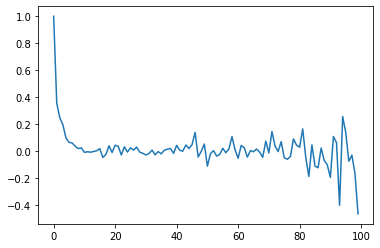

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])


7
8
5
5
5
5
5
5
9
5
7
11
10
10
7
5
5
8
6
6
6
(167, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


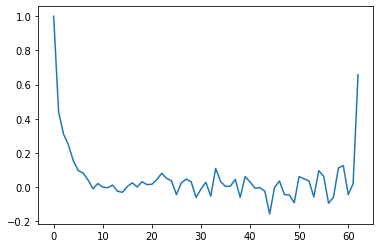

5
13
6
5
10
7
6
5
5
9
5
7
7
8
5
5
6
7
6
7
8
5
7
5
(198, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


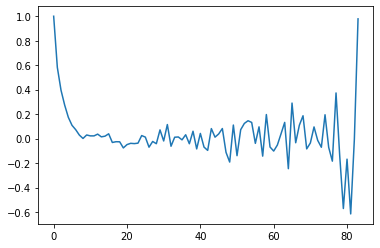

5
10
6
6
7
6
5
5
5
11
6
5
5
5
7
5
5
5
6
11
6
6
5
6
6
5
8
5
5
5
5
7
7
7
6
5
6
5
5
5
5
5
8
5
5
6
6
5
5
6
5
8
6
7
7
5
5
5
6
5
8
5
5
8
5
5
13
5
5
6
7
5
5
(680, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


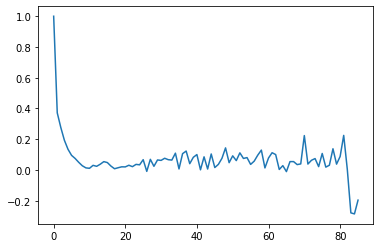

5
6
6
5
7
5
7
6
6
5
5
6
5
6
5
5
5
7
6
9
5
7
5
6
5
5
7
9
5
6
5
7
6
7
5
5
5
5
7
6
5
6
5
(350, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


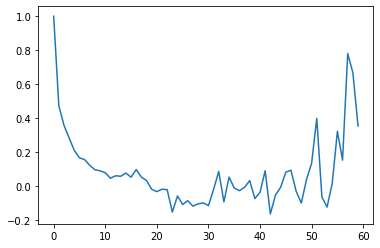

5
6
6
5
6
14
13
5
6
6
6
5
11
5
5
5
6
5
5
6
8
5
6
5
6
5
5
7
5
5
(379, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


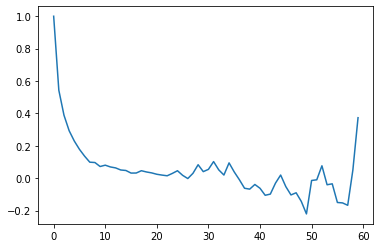

9
5
5
7
5
7
13
5
8
5
5
7
5
5
8
5
7
7
10
7
8
5
5
6
8
5
5
15
5
5
5
5
7
5
5
5
7
6
9
5
9
9
5
6
5
5
6
9
6
5
7
5
5
7
7
6
6
6
6
5
5
5
5
(542, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/analyse_tracks.py:110: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.dot(v1,v2)/(norm(v1) * norm(v2))
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lau/GIT/FRC_Thesis/CPM_code/analyse_tracks.py:93: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.dot(v1,v2)/(norm(v1) * norm(v2))


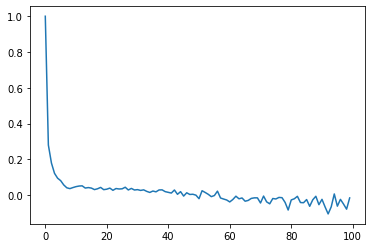

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])


5
5
7
9
5
5
6
6
7
5
5
5
5
5
5
7
6
5
5
7
5
7
5
5
7
5
5
[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        

/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


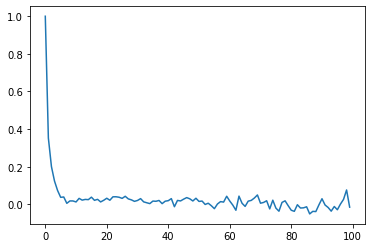

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])


5
6
7
6
5
6
5
6
5
5
5
5
7
6
5
5
5
6
5
5
5
7
5
5
7
5
6
6
7
6
5
10
6
12
6
5
5
7
6
8
5
7
10
8
5
6
8
5
10
5
6
8
5
5
8
5
5
5
5
8
5
5
5
8
6
8
10
7
5
5
6
5
5
(1020, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


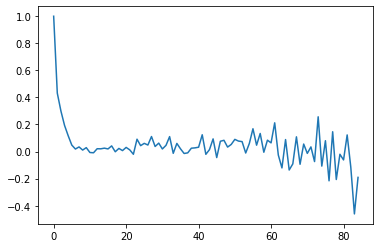

5
5
5
8
5
5
5
6
5
5
5
5
6
6
6
5
5
5
6
6
10
9
5
6
5
8
7
5
5
5
5
5
5
5
5
5
5
5
6
5
(252, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


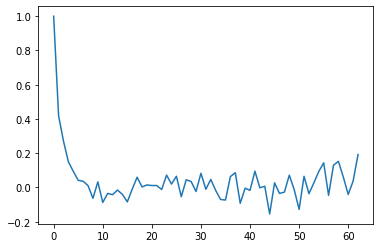

6
5
5
9
8
5
7
6
5
5
5
5
5
6
5
7
5
6
7
5
5
5
9
7
5
(159, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


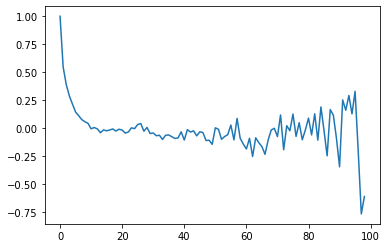

8
5
7
6
8
5
6
10
7
5
5
5
5
5
8
7
6
5
(198, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


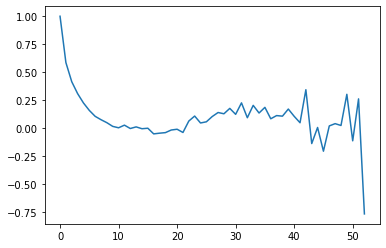

5
8
7
8
5
6
5
6
6
8
5
7
5
15
6
5
8
6
5
5
5
5
5
5
8
11
5
8
10
5
6
6
6
5
11
5
9
5
7
7
7
8
9
5
6
5
5
6
8
6
5
5
5
6
5
5
7
5
6
5
7
5
6
5
6
5
5
5
5
9
6
5
7
5
7
7
6
5
9
5
6
6
5
(680, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/analyse_tracks.py:110: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.dot(v1,v2)/(norm(v1) * norm(v2))
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/lau/GIT/FRC_Thesis/CPM_code/analyse_tracks.py:93: RuntimeWarning: invalid value encountered in double_scalars
  dot = np.dot(v1,v2)/(norm(v1) * norm(v2))


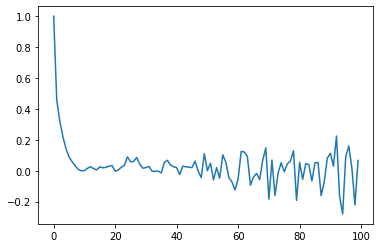

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])


6
6
7
8
6
5
5
6
6
6
5
6
6
9
10
6
5
5
7
6
7
5
6
5
6
6
7
5
5
9
9
7
5
6
6
5
5
9
7
6
6
5
5
6
5
9
7
6
5
5
5
5
7
7
7
5
5
8
5
5
5
9
5
5
6
6
5
6
6
6
5
8
5
5
6
5
5
5
6
5
6
10
6
6
5
5
9
6
6
6
6
6
5
5
5
5
5
5
6
5
5
8
14
8
5
5
5
7
5
5
6
5
5
6
7
6
6
6
5
5
6
6
5
5
9
5
7
6
6
5
5
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan  0.
  0.33333333  0.         -1.                 nan]
6
7
6
5
5
5
7
5
6
8
5
6
5
7
7
7
6
6
6
5
(1353, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


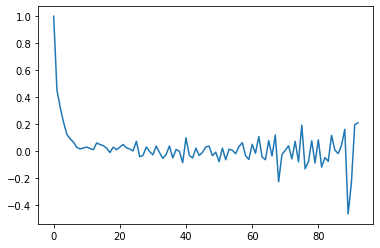

5
5
6
5
19
5
10
6
5
8
5
7
6
7
5
6
5
5
5
5
7
6
5
5
7
6
6
6
6
6
8
9
11
11
8
9
9
7
5
7
6
12
5
5
8
5
6
11
6
5
6
5
5
5
5
5
5
5
6
5
5
5
7
5
5
8
8
5
5
5
5
6
6
6
9
5
6
8
6
9
6
10
8
5
5
7
8
7
5
6
5
7
5
10
5
5
8
6
6
11
5
5
5
8
6
5
5
5
5
5
(755, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


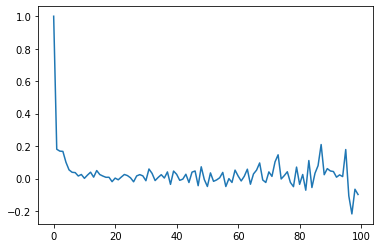

/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])


5
10
8
10
6
5
7
7
5
10
5
5
5
5
5
6
6
5
6
7
6
5
5
5
5
(298, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:103: RuntimeWarning: invalid value encountered in greater
  max_indeces = np.where(ac > .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:104: RuntimeWarning: invalid value encountered in less
  min_indeces = np.where(ac < .5)[0]
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:113: RuntimeWarning: invalid value encountered in greater
  dt_0 = max(np.where(ac > .5)[0])
/home/lau/GIT/FRC_Thesis/CPM_code/OrderNpersist.py:114: RuntimeWarning: invalid value encountered in less
  dt_1 = min(np.where(ac < .5)[0])
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/lau/anaconda2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


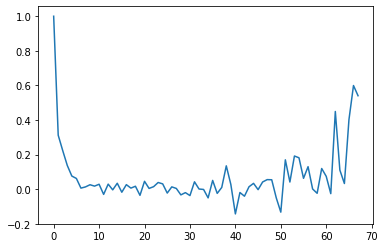

6
5
5
5
8
5
6
6
6
6
6
5
11
6
5
5
9
6
9
5
5
6
9
5
8
8
5
(192, 4, 3)
lenght of order shoulde be min_lenght. Min_lenght 4 == 4
Time in track: 0
Time in track: 1
Time in track: 2
Time in track: 3


In [15]:
rows  = []
deviation_rows = []

for filename in files: 
    # extract tracks : 
    df = pd.read_csv(filename, sep="\t", names=['cell_id', 'time_id', 'time', 'x', 'y', 'z'])   
    df['experiment'] = filename[19:28]
    df['cell_type'] = filename[29:32]
    df['movie'] = filename[38:39]
    ids = df.cell_id.unique()
    tracks = [df[df.cell_id == i][['x','y','z']].to_numpy() for i in ids]
    # filter out super short tracks: 
    #tracks = [t for t in tracks if len(t) > 30]
    
    # pooled persistance : 
    dts = 100
    dots_for_dts = [[] for i in range(dts)]
    pooled_dts = [auto_cor_pooled(t,dots_for_dts,dts) for t in tracks]
    averages = [np.mean(i) for i in dots_for_dts]
    plt.plot(averages)
    pooled_pers = Persist_tracks([averages])
    if len(pooled_pers) == 0:
        pooled_pers = np.nan
    else:
        pooled_pers = pooled_pers[0]
    
    # speed : 
    vec_tracks = np.array([to_vecs(t) for t in tracks])
    speeds = [[norm(v) for v in vec_track] for vec_track in vec_tracks]
    speeds = [item for sublist in speeds for item in sublist]
    speed = np.mean(speeds)
    std_speed = np.std(speeds)
    
    #peristance : 
    autocors = [new_auto(t) for t in tracks]
#     for ac in autocors:
#         plt.plot(ac)
    plt.show()
    half_times = Persist_tracks(autocors)
    #print(half_times)
    ht = np.average(half_times)
    std_ht = np.std(half_times)
    
    #order : 
    ordr1 = Global_order(vec_tracks)
    ordr2,std_ordr2 = OrderAt_T(vec_tracks)
    lcl_ordrs = local_order(tracks,vec_tracks)
    lcl_ordr = np.average(lcl_ordrs)
    std_lcl = np.std(lcl_ordrs)
    
    
    rows.append([df.cell_type[0],df.experiment[0],len(tracks),speed,ht,ordr1,ordr2,lcl_ordr,pooled_pers])
    deviation_rows.append([df.cell_type[0],df.experiment[0],std_speed,std_ht,std_ordr2,std_lcl])

In [18]:
df1 = pd.DataFrame(data = rows, columns = ['cell_type','experiment','n_cells', 'speed', 'persistance', 'order', 'order_t','local_order','pooled_pers'])
# scale order to n cells
df1['order_t'] = df1.order/df1.n_cells

In [19]:
df1

,cell_type,experiment,n_cells,speed,persistance,order,order_t,local_order,pooled_pers
0,cd4,exp090814,303,4.225268,4.990826,438.293084,1.446512,0.084854,0.657690
1,cd4,exp090814,606,6.199917,3.231265,3271.171282,5.397972,0.066466,0.916721
2,cd8,exp090814,167,4.201201,3.745013,312.541250,1.871504,0.114457,0.775700
3,cd8,exp090929,198,5.111871,3.933604,683.758158,3.453324,0.102121,17.501122
4,cd8,exp090814,680,6.944257,3.084875,2268.339199,3.335793,0.062859,16.476366
5,cd8,exp090929,350,4.961855,4.454429,2202.573033,6.293066,0.069372,0.795477
6,cd4,exp101210,379,5.239510,3.284945,2212.117377,5.836721,0.056025,8.473314
7,cd8,exp101210,542,5.290706,3.663329,4501.351130,8.305076,0.050155,1.279680
8,cd8,exp101208,1163,3.101584,4.497541,6746.135367,5.800632,0.020170,0.694327
9,cd4,exp101208,1020,4.090482,3.799975,5796.920979,5.683256,0.025393,0.772483


In [13]:
#save : 
df1.to_csv('ANLSYS2/Mlab.csv')
df2 = pd.DataFrame(data =deviation_rows, columns = ['cell_type','experiment', 'speed', 'persistance', 'order_t','local_order'])
df2.to_csv('ANLSYS2/Mlab_std.csv')      
           

In [20]:
# print averages : 
mean = df1[['speed','persistance','order','order_t','local_order','pooled_pers']].mean()
print("AVERAGE ALL CELL TYPES")
print(mean)
# print(np.average(df1.speed),np.average(df1.persistance),np.average

# Split cd4 / cd8
cd4 = df1[df1.cell_type == 'cd4'][['speed','persistance','order','order_t','local_order','pooled_pers']].mean()
print("CD4")
print(cd4)
cd8 = df1[df1.cell_type == 'cd8'][['speed','persistance','order','order_t','local_order','pooled_pers']].mean()
print("CD8")
print(cd8)

AVERAGE ALL CELL TYPES
speed             5.104099
persistance       3.844203
order          2510.863716
order_t           4.518910
local_order       0.073770
pooled_pers       6.146018
dtype: float64
CD4
speed             5.121274
persistance       3.815030
order          2687.261896
order_t           4.603643
local_order       0.072868
pooled_pers       1.667175
dtype: float64
CD8
speed             5.086925
persistance       3.873376
order          2334.465537
order_t           4.434177
local_order       0.074672
pooled_pers      10.624862
dtype: float64


In [ ]:
# print averages : 
mean = df1[['speed','persistance','order','order_t']].mean()
print("AVERAGE ALL CELL TYPES")
print(mean)
# print(np.average(df1.speed),np.average(df1.persistance),np.average

# Split cd4 / cd8
cd4 = df1[df1.cell_type == 'cd4'][['speed','persistance','order','order_t']].mean()
print("CD4")
print(cd4)
cd8 = df1[df1.cell_type == 'cd8'][['speed','persistance','order','order_t']].mean()
print("CD8")
print(cd8)

In [ ]:
#         for i,p in enumerate(pos):
#             print(p,binned_pos[i])
#         binned_vecs = sparse_hist(vec_pos,100,bin_index = True)
#         #print(len(binned_vecs.keys()))
#         for key,val in binned_vecs.items():
#             print(key)
#             print(val)
        break
        exit()
        running_vec = 0
#         # loop over bin borders : 
#         for border in bin_border:
#             # loop over vecs at t
#             for tup in vec_pos:
#                 if all(tup[0] )
        
        
#     vec_tracks = np.array([to_vecs(t) for t in tracks])
#     print(vec_tracks.shape)
#     print()
#     # list of order 
#     orders = []
#     for i in range(len(vec_tracks[0])):
#         vecs_at_t = vec_tracks[:,i]
#         # tuple vec wit position : 
#         vec_pos = [(tracks[j][i],vecs_at_t[j]) for j in range(len(vecs_at_t))]
#         vecs_at_t = [t for t in vecs_at_t if norm(t[1]) != 0]
#         pairs = combinations(vec_pos,2)
        
        
#         orders.append(np.average(cosines))
